In [1]:
## import stuff
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro, levene

# This is Ass. 3 - Exploratory data analysis and hypotheses testing
## Hausarbeit im Modul Data Analytics mit Python SS23

focus is on cleaning data, visualisation, some statistics 
There are 3 steps to do:
1. Data Preperation
2. Data Visualization
3. Hypothesis Testing

# 1. Data preparation

#### 1.1 Import the data and perform data cleaning if needed. Describe what you are doing
#### 1.2 Determine the measurement scale of each attribute in the data set. Briefly explain your decision.

#### 1.1 import and clean data

In [38]:
## get data
data = pd.read_csv("03_Assignment Data.csv")
data.head()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order Date        9994 non-null   object 
 1   Shipment Date     9994 non-null   object 
 2   Segment           9994 non-null   object 
 3   City              9994 non-null   object 
 4   State             9795 non-null   object 
 5   Region            9994 non-null   object 
 6   Product ID        9601 non-null   object 
 7   Product Category  9994 non-null   object 
 8   Profit            9799 non-null   float64
dtypes: float64(1), object(8)
memory usage: 702.8+ KB


In [39]:
print(data.isnull().sum())

Order Date            0
Shipment Date         0
Segment               0
City                  0
State               199
Region                0
Product ID          393
Product Category      0
Profit              195
dtype: int64


So while checking for missing values I figured that I have to look into the profit, product ID and State columns a little deeper.
State and profit will be important in the later tasks, thus I will look deeper into that. 
Firstly Im replacing values from product ID with a placeholder, since that column wont be essential for my later analysis. 
State might be replaceable, since we have city and region.

In [40]:
data['Product ID'] = data['Product ID'].fillna('Unknown')
#print(data.isnull().sum())

In [41]:
## Missing values in the "State" column I will replace with the most frequent state for each combination of "City" and "Region"
## To do that I will create a mapping of the mode (most frequent value) of the "State" for each group
## and then use that to fill the missing values.
# Create a mapping of the mode of 'State' for each group of 'City' and 'Region'
state_mapping = data.groupby(['City', 'Region'])['State'].agg(pd.Series.mode).to_dict()

# Define a function to apply to the missing values in 'State'
def fill_state(row):
    if pd.isnull(row['State']):
        return state_mapping.get((row['City'], row['Region']))
    else:
        return row['State']

# Apply the function to the 'State' column
data['State'] = data.apply(fill_state, axis=1)
##print(data.isnull().sum())

Regarding the profit column with null values I will just drop the values, since I have 195 entries and that is 1.96 %, so a non essential amount of missing data. There is another issue bugging me though, I have 461 entries with a profit of 0.0. In a real life example I would check with my business partner, in order to get more business knowledge if that is a thing that they will sell stuff for zero profit. It might be a reasonable sales approach for big customers to sell the first stuff cheaper or with 0 profit, but I just do not know that. Hence I will drop the values, in real life I would talk to my business partner to get more business understanding

In [6]:
zero_profit_data = data[data['Profit'] == 0.0]
zero_profit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 461 entries, 33 to 9993
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order Date        461 non-null    object 
 1   Shipment Date     461 non-null    object 
 2   Segment           461 non-null    object 
 3   City              461 non-null    object 
 4   State             461 non-null    object 
 5   Region            461 non-null    object 
 6   Product ID        461 non-null    object 
 7   Product Category  461 non-null    object 
 8   Profit            461 non-null    float64
dtypes: float64(1), object(8)
memory usage: 36.0+ KB


In [42]:
# Remove rows with 'Profit' as NaN
data = data[data['Profit'].notna()]
# Remove rows with 'Profit' as 0.0
data = data[data['Profit'] != 0.0]
## testing my code to make sure I have no missing values or profit =0.0 anymore
##print(data.isnull().sum())
##zero_profit_data = data[data['Profit'] == 0.0]
##zero_profit_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 461 entries, 33 to 9993
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order Date        461 non-null    object 
 1   Shipment Date     461 non-null    object 
 2   Segment           461 non-null    object 
 3   City              461 non-null    object 
 4   State             461 non-null    object 
 5   Region            461 non-null    object 
 6   Product ID        461 non-null    object 
 7   Product Category  461 non-null    object 
 8   Profit            461 non-null    float64
dtypes: float64(1), object(8)
memory usage: 36.0+ KB


Regarding later task I will have to visualize by month and by state each looking at the profit. Thus I will check my profit column for a distribution and outliners. 
Furthermore, since I have to visualize how the profit has changed on a monthly basis I will check if 'Order Date' is not in datetime format and convert if necessary. 
After that I have to create a column "Month" as preliminary work to visualize by month. 

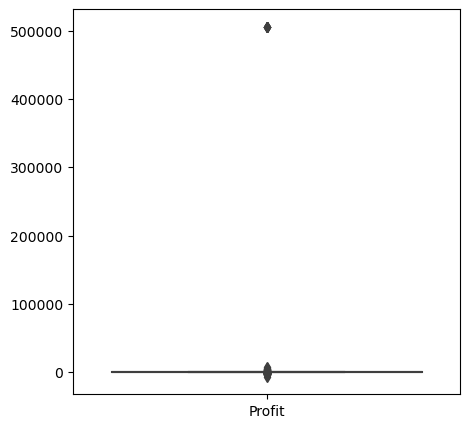

In [9]:
## checking for and removing outliers
data_profit = data[['Profit']]
# Plot Boxplot
fig, ax = plt.subplots(figsize=(5, 5))
sns.boxplot(data=data_profit) # Use a boxplot to visualize any outliers
plt.show()

In [10]:
Q1 = data['Profit'].quantile(0.25)
Q3 = data['Profit'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
#outliers = data[(data['Profit'] < lower_bound) | (data['Profit'] > upper_bound)]
#print(outliers)
# Remove outliers
data = data[(data['Profit'] >= lower_bound) & (data['Profit'] <= upper_bound)]

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7584 entries, 0 to 9992
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order Date        7584 non-null   object 
 1   Shipment Date     7584 non-null   object 
 2   Segment           7584 non-null   object 
 3   City              7584 non-null   object 
 4   State             7584 non-null   object 
 5   Region            7584 non-null   object 
 6   Product ID        7584 non-null   object 
 7   Product Category  7584 non-null   object 
 8   Profit            7584 non-null   float64
dtypes: float64(1), object(8)
memory usage: 592.5+ KB


In [12]:
## now checking for column order date in datetime format and converting
print(data['Order Date'].dtypes)
##unfortunately if is type object (,,>﹏<,,)

object


In [13]:
data['Order Date'] = pd.to_datetime(data['Order Date'])
print(data['Order Date'].dtypes)

datetime64[ns]


In [14]:
## extracting month and creating new column
data['Order Month'] = data['Order Date'].dt.month
data.head()

,Order Date,Shipment Date,Segment,City,State,Region,Product ID,Product Category,Profit,Order Month
0,2020-11-08,2020-11-11,Consumer,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,41.9136,11
2,2020-06-12,2020-06-16,Others,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,6.8714,6
4,2019-10-11,2019-10-18,Consumer,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,2.5164,10
5,2018-06-09,2018-06-14,Consumer,Los Angeles,California,West,FUR-FU-10001487,Furniture,14.1694,6
6,2018-06-09,2018-06-14,Consumer,Los Angeles,California,West,OFF-AR-10002833,Office Supplies,1.9656,6


### 1.2 Determine the measurement scale of each attribute in the data set. Briefly explain your decision.

In [15]:
print(data.dtypes)

Order Date          datetime64[ns]
Shipment Date               object
Segment                     object
City                        object
State                       object
Region                      object
Product ID                  object
Product Category            object
Profit                     float64
Order Month                  int64
dtype: object


### General principle

1. datetime64[ns]: This represents date and/or time values. These are usually interval scale data.
2. object: This is usually a string or a mix of other data types. In many cases, these columns may hold nominal scale data (like names, ids), but they can also hold ordinal data if the data are coded as text (like 'low', 'medium', 'high').
3. int64 or float64: These are numeric types. They can hold ordinal data (like rankings), interval data (like temperatures in Celsius or Fahrenheit, dates), or ratio data (like height, weight, age). The actual scale will depend on the nature of the data.

### for my dataset

1. Order Date: Interval scale - Dates are measured on an interval scale, as there are equal intervals between consecutive dates and you can perform arithmetic operations on them.
1. Shipment Date: Interval scale - The same reasoning as "Order Date" applies here.
1. Segment: Nominal scale - The "Segment" attribute is a categorical variable. The values like "Consumer" or "Others" are categories that have no inherent order, so this is a nominal scale.
1. City: Nominal scale - City names are categorical and can't be ordered in a meaningful way, so this is a nominal scale.
1. State: Nominal scale - State names are categorical and don't have a meaningful order, so this is a nominal scale.
1. Region: Nominal scale - Regions, similar to states and cities, fall into the category of nominal data, as there's no inherent order or ranking in the name of regions.
1. Product ID: Nominal scale - Though "Product ID" looks numeric, it's really a categorical variable used to uniquely identify products. There's no meaningful order or difference, so this is a nominal scale.
1. Product Category: Nominal scale - The categories like "Furniture", "Office Supplies" or "Technology" are categorical and have no inherent order, so this is a nominal scale.
1. Profit: Ratio scale - Profit can be measured on a ratio scale. It has a true zero point (no profit) and you can make relative comparisons (e.g., "Profit A is twice as large as Profit B").
1. Order Month: Interval scale - The months of the year, from 1 (January) to 12 (December), have a specific order and equal intervals between them.


# 2. Data Visualization
1. Visualize how the profit has changed on a monthly basis using one appropriate chart. Describe and interpret the results.
2. The company wants to know, which states have been profitable and in which states occurred a loss. Visualize the profit or loss amongst different states using one appropriate chart. Describe and interpret the results.
3. Visualize the state-wise profit or loss according to the product categories using one appropriate chart. Describe and interpret the results.
4. Visualize the distribution of the profit according to the product categories using one appropriate chart. Describe and interpret the result

### 2.1 Visualize how the profit has changed on a monthly basis using one appropriate chart. Describe and interpret the results.

In [16]:
data.head()

,Order Date,Shipment Date,Segment,City,State,Region,Product ID,Product Category,Profit,Order Month
0,2020-11-08,2020-11-11,Consumer,Henderson,Kentucky,South,FUR-BO-10001798,Furniture,41.9136,11
2,2020-06-12,2020-06-16,Others,Los Angeles,California,West,OFF-LA-10000240,Office Supplies,6.8714,6
4,2019-10-11,2019-10-18,Consumer,Fort Lauderdale,Florida,South,OFF-ST-10000760,Office Supplies,2.5164,10
5,2018-06-09,2018-06-14,Consumer,Los Angeles,California,West,FUR-FU-10001487,Furniture,14.1694,6
6,2018-06-09,2018-06-14,Consumer,Los Angeles,California,West,OFF-AR-10002833,Office Supplies,1.9656,6


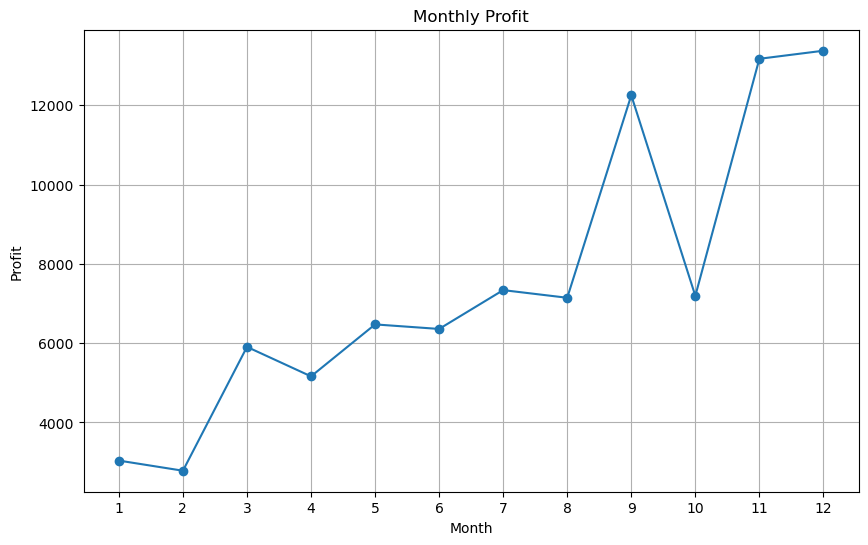

In [17]:
## in order to visualize how the profit has changed on a monthly basis
## we need to aggregate the data by the month and then sum up the profits for each month.
# Ensure the data is sorted by 'Order Date' before groupby operation
data.sort_values('Order Date', inplace=True)
# Group data by 'Order Month' and calculate sum of 'Profit' for each month
monthly_profit = data.groupby('Order Month')['Profit'].sum()

plt.figure(figsize=(10,6))
plt.plot(monthly_profit.index, monthly_profit.values, marker='o')

# Create list of months
months = np.arange(1,13)
# Set xticks to be every month
plt.xticks(months)

plt.xlabel('Month')
plt.ylabel('Profit')
plt.title('Monthly Profit')
plt.grid(True)
plt.show()

In [18]:
monthly_profit

Order Month
1      3036.9112
2      2781.4481
3      5905.0696
4      5161.7601
5      6472.2778
6      6357.7231
7      7337.1435
8      7144.2519
9     12251.6118
10     7192.6237
11    13172.4443
12    13376.1021
Name: Profit, dtype: float64

The numbers suggest a certain degree of seasonality in the data, with low profits at the beginning of the year, a steady increase into the middle of the year, and then a significant rise towards the end of the year.

1. The profits start relatively low in the year, with January and February being the months with the lowest profits: These months typically have lower profits, perhaps due to a slowdown following the holiday season. For office supplies and technology, it might also be related to the fact that businesses and individuals have already invested in necessary supplies or technology at the end of the previous year and thus the demand is low.

1. Spring (March - April): The profits increase during these months, which could be due to the new fiscal year in businesses (often starting in April), resulting in new budgets for office supplies and technology.

1. Late Spring to Summer (May - July): There is a steady rise in profits, possibly driven by businesses gearing up for the second half of the year and investing in office furniture, technology upgrades, or restocking supplies. For some companies, the end of a fiscal quarter (June) could also mean some budget needs to be spent.

1. Late Summer (August): There is a slight decrease in profits compared to July, but the performance is still strong, perhaps driven by back-to-school (the company is located in the US) shopping for both office supplies and furniture.

1. Fall (September): Profits jump significantly, possibly due to businesses preparing for Q4 and schools/colleges/universities starting their new academic year, leading to increased demand for office supplies, technology, and furniture.

1. Early Holiday Season (October): There is a drop in profits, but the performance is still strong. It might be a transition period between back-to-school and holiday shopping.

1. Holiday Season (November - December): These months see the highest profits, likely due to holiday shopping and year-end business purchases. Businesses might be investing in new furniture or technology for the upcoming year, or using up their remaining budget. Holiday sales and promotions might also increase consumer spending during this time.

### 2.2 The company wants to know, which states have been profitable and in which states occurred a loss. Visualize the profit or loss amongst different states using one appropriate chart. Describe and interpret the results. 

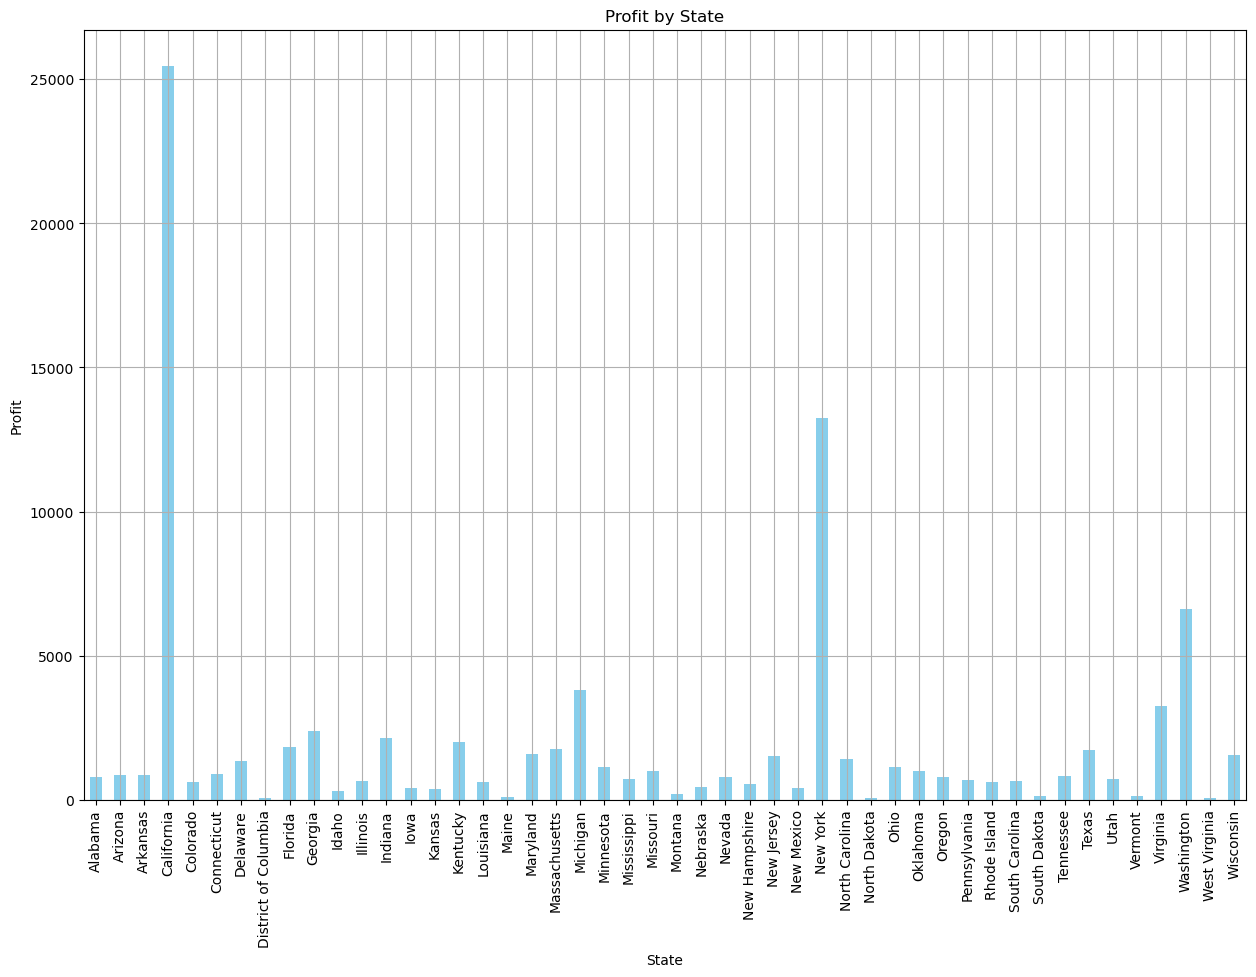

In [19]:
## The first step is to calculate the total profit for each state using the groupby function in pandas. 
## visualize it using a bar plot, which is an effective way to compare numerical quantities across different categories 

# Group the data by 'State' and calculate the sum of 'Profit' for each state
state_profit = data.groupby('State')['Profit'].sum()
# Plotting
plt.figure(figsize=(15,10))
state_profit.plot(kind='bar', color='skyblue')
plt.ylabel('Profit')
plt.xlabel('State')
plt.title('Profit by State')
plt.grid(True)
plt.show()

In [43]:
## looking at the numbers
state_profit

State
Alabama                   785.0985
Arizona                   869.3112
Arkansas                  865.7149
California              25448.4725
Colorado                  621.6575
Connecticut               878.1629
Delaware                 1353.6929
District of Columbia       75.9446
Florida                  1834.5335
Georgia                  2401.3248
Idaho                     311.6860
Illinois                  653.9118
Indiana                  2127.6948
Iowa                      395.7159
Kansas                    381.3975
Kentucky                 2008.2563
Louisiana                 613.6967
Maine                      93.7338
Maryland                 1593.3364
Massachusetts            1777.1695
Michigan                 3814.7383
Minnesota                1143.0175
Mississippi               707.5231
Missouri                  991.2571
Montana                   209.5317
Nebraska                  425.1968
Nevada                    791.1504
New Hampshire             537.6837
New Jersey    

1. <b> Most Profitable States:</b> California and New York are by far the most profitable states, with profits of about 25,448 and 13,246 respectively. This might be expected due to their large populations and the presence of several large cities.
1. <b> Moderately Profitable States:</b> States such as Virginia, Michigan, and Washington are moderately profitable with profits in the thousands but not reaching the heights of California and New York. They might still represent significant markets for the company due to their size or due to particular local factors that make the products more popular.
1. <b> Least Profitable States:</b> States like North Dakota and West Virginia have the lowest profits, around 60 and 43 respectively. This could be due to many factors including a smaller customer base, less marketing or distribution effort in these regions, or less demand for the company's products.
1. <b> Loss Making States:</b> In this data, it doesn't look like any states are making losses as all the numbers are positive. I did drop alot of null and 0.0 values though. In real life I would have to check for that data with a representative of the company in order to get more business understanding. In addition we dropped alout of outliners, so in real life I would to a graph and analysis including the outliners as well and compare the results. 

This data could guide the company's future strategy. For example, they could focus on expanding in the most profitable states, or they could investigate why they're not making more profits in the less profitable states. However, the company should also consider other factors like the size of the customer base in each state, the cost of doing business in each state, and the potential for future growth.

Furthermore they should perform a user research analysis for the most profitable states on the needs of the products needed. I assume in those states they have a high visibility and it is easier to reach the existing customers and offer the new products

### 2.3 Visualize the state-wise profit or loss according to the product categories using one appropriate chart. Describe and interpret the results. 

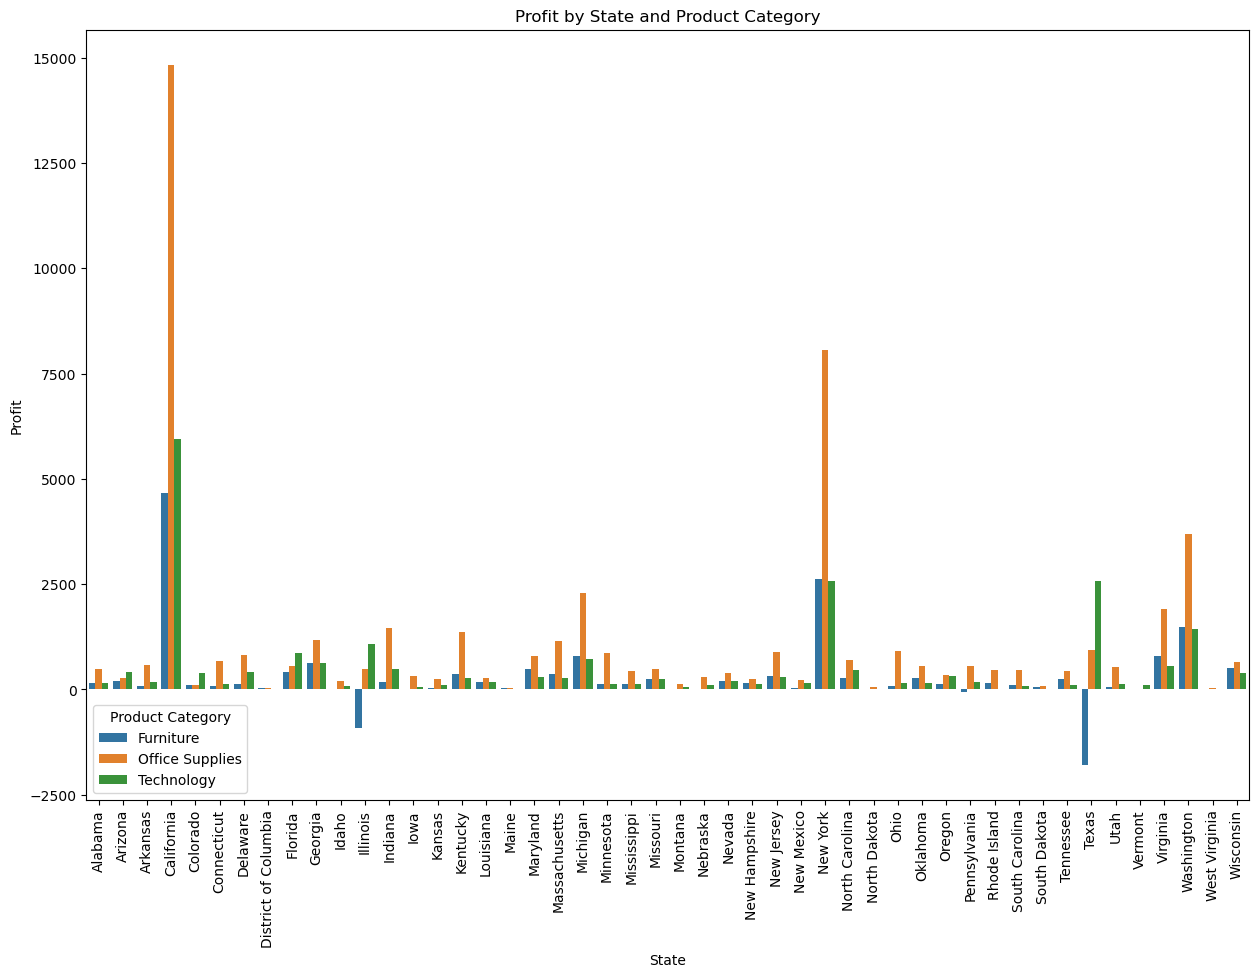

In [21]:
# Group the data by 'State' and 'Product Category', and calculate the sum of 'Profit' for each group
state_category_profit = data.groupby(['State', 'Product Category'])['Profit'].sum().reset_index()
# Create a grouped bar plot
plt.figure(figsize=(15,10))
sns.barplot(x='State', y='Profit', hue='Product Category', data=state_category_profit)
plt.xticks(rotation=90)
plt.ylabel('Profit')
plt.xlabel('State')
plt.title('Profit by State and Product Category')
plt.show()

In [22]:
## looking at the numbers
## pd.set_option('display.max_rows', 150)
## state_category_profit

1. <b>California and New York stand out as the most profitable states across all product categories.</b> This could be due to a variety of factors, including a larger customer base, higher demand, or successful marketing strategies in these states. For instance, California has the highest profit in all categories with 4660.3864 in Furniture, 14831.9639 in Office Supplies, and 5956.1222 in Technology. New York follows closely, especially in Office Supplies and Technology.
1. <b>Office Supplies tend to be the most profitable category in most states.</b> This could be attributed to a higher demand for these products, possibly due to their recurrent use and necessity in both homes and offices.
1. <b>There are states where certain categories are running at a loss.</b> For instance, Furniture in Illinois and Texas is generating negative profits (-910.2991 and -1787.7013, respectively). This suggests that there might be issues related to cost, pricing, supply chain, or demand that are impacting profits for this category in these states. Similarly, Furniture and Technology have generated less profit or even losses in Pennsylvania.
1. <b>Certain states, such as North Dakota and West Virginia,</b> have only one or two product categories listed. This is probly due to a lack of data or if these states genuinely only sell in these categories through the company. This could point to opportunities to expand the range of products offered in these states.
1. <b>Based on these findings</b>, the company might want to consider focusing more on Office Supplies in general. Furthermore, it would be worthwhile investigating why certain product categories are performing poorly in specific states and addressing those issues to improve overall profitability. At the same time, the company might explore opportunities for expansion in states with fewer product categories.
1. <b>For further interpretations </b> more information about the company's overall strategy, costs, market conditions, and other factors are necessary

### 2.4 Visualize the distribution of the profit according to the product categories using one appropriate chart. Describe and interpret the result

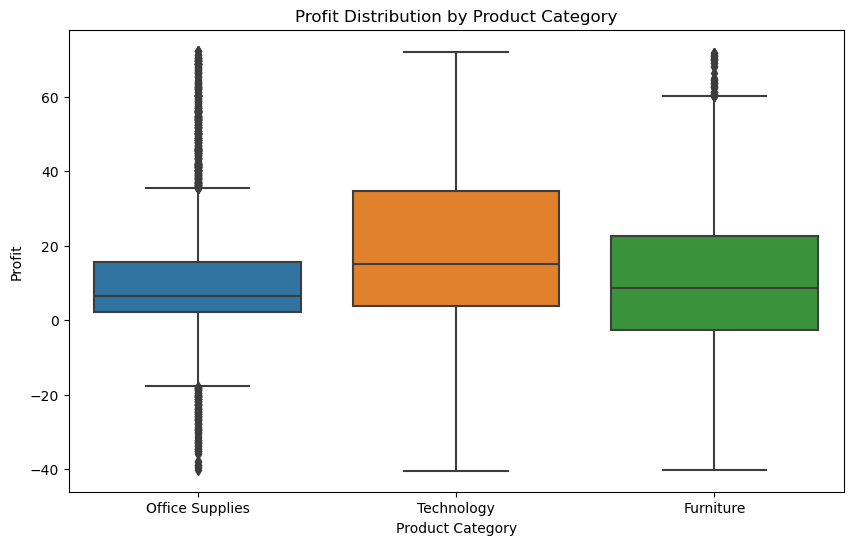

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Product Category', y='Profit', data=data)
plt.title('Profit Distribution by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Profit')
plt.show()

In [24]:
##getting some numbers for interpretations
## Group the data by 'Product Category' and calculate the median
medians = data.groupby('Product Category')['Profit'].median()

# Calculate the Interquartile Range (IQR)
Q1 = data.groupby('Product Category')['Profit'].quantile(0.25)  # 1st quartile
Q3 = data.groupby('Product Category')['Profit'].quantile(0.75)  # 3rd quartile
IQR = Q3 - Q1  # Interquartile range

# Calculate the range
ranges = data.groupby('Product Category')['Profit'].max() - data.groupby('Product Category')['Profit'].min()

# Define the bounds for the outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify the outliers for each category
outliers = []
for category in data['Product Category'].unique():
    category_data = data[data['Product Category'] == category]['Profit']
    category_outliers = category_data[(category_data < lower_bound[category]) | (category_data > upper_bound[category])].values
    outliers.append(category_outliers)

# Print all the calculated statistics
print('Medians:\n', medians)
print('Interquartile Ranges:\n', IQR)
print('Ranges:\n', ranges)
print('Outliers:\n', outliers)


Medians:
 Product Category
Furniture           8.5346
Office Supplies     6.4128
Technology         15.1116
Name: Profit, dtype: float64
Interquartile Ranges:
 Product Category
Furniture          25.1658
Office Supplies    13.3336
Technology         30.9210
Name: Profit, dtype: float64
Ranges:
 Product Category
Furniture          112.1240
Office Supplies    112.6128
Technology         112.4664
Name: Profit, dtype: float64
Outliers:
 [array([-18.2525, -23.716 ,  36.693 , -22.6716,  40.872 ,  45.9754,
        38.1576,  49.014 ,  47.8152, -31.6712,  41.1528,  36.5742,
       -25.737 ,  59.0112,  60.2553, -39.4565, -35.928 ,  60.2553,
        50.4063, -37.7332,  52.776 ,  45.84  , -31.008 ,  68.8464,
        56.2032,  56.9772, -30.555 ,  51.36  ,  66.5088,  41.68  ,
       -38.1114,  50.4711, -20.5623,  36.4044, -22.7964,  62.1376,
       -35.178 ,  67.86  ,  68.8464,  44.955 ,  50.328 ,  38.5722,
       -21.888 ,  68.585 , -26.8544, -29.3436,  53.2608,  37.23  ,
        41.823 ,  42.8148,

### Medians:
The median represents the middle value of a dataset. It's particularly useful in datasets with outliers as it isn't skewed by exceptionally high or low values.

1. Furniture: 8.5346
2. Office Supplies: 6.4128
3. Technology: 15.1116

This means that for every product sold, on average, the profit from selling Technology items is higher than that of Furniture and Office Supplies.

### Interquartile Ranges (IQR):
The IQR is the range within which the central 50% of values fall. It's calculated as the difference between the 75th percentile (Q3) and the 25th percentile (Q1) of data. It gives us an idea of the variability of profits within each category.

1. Furniture: 25.1658
2. Office Supplies: 13.3336
3. Technology: 30.9210

These numbers show that Technology items have the largest IQR, indicating more variability in the profits. Furniture also has a fairly high variability, whereas Office Supplies have the least.

### Ranges:
The range is the difference between the maximum and minimum values in a dataset. It gives an indication of statistical dispersion or spread.

1. Furniture: 112.1240
2. Office Supplies: 112.6128
3. Technology: 112.4664

This tells us that the spread of profits (from the least profitable to the most profitable item) is similar across all three categories.

### Outliers:
Outliers are values that are significantly higher or lower than most of the values in your dataset. They can sometimes indicate data entry errors, other times they may indicate important features of the dataset. In the context of sales data, outliers could indicate exceptionally successful or unsuccessful products.
Looking at the plot there is following interpretation:

1. Furniture: Almost all outliers and in the positive profit
2. Office Supplies: Product category with the most outliers in positive and negative profit
3. Technology: Almost no outliers

# 3. Hypothesis testing
Formulate a hypothesis and a null hypothesis for each of the following examples. Describe and interpret your results. Keep in mind to always check for relevant preconditions (explain what you are doing).

1. Does the product category "technology" generate higher profit compared to products that do not belong to this category?
2. Is there any significant difference in profit generated from all three different categories of products?
3. Is there a difference in the number of technology purchases between the consumer segment and the non-consumer segment?

### 3.1 Does the product category "technology" generate higher profit compared to products that do not belong to this category?

<b> Hypothesis (H1): The product category "technology" generates a higher profit compared to products that do not belong to this category.

<b> Null Hypothesis (H0): There is no difference in profit generated by products from the "technology" category and those that do not belong to this category.

To test these I will use a two-sample t-test which is used to determine if two population means are equal. 

### The preconditions for a two-sample t-test are:

1. The data samples should be normally distributed. We can use methods like the Shapiro-Wilk test or visual methods like Q-Q plots to check this.
1. The data samples should be independent of each other.
1. The variances of the populations from which the samples are taken are equal 

In [25]:
# Separating profits based on product categories
tech_profits = data[data['Product Category'] == 'Technology']['Profit']
non_tech_profits = data[data['Product Category'] != 'Technology']['Profit']

# Performing the t-test
t_stat, p_val = stats.ttest_ind(tech_profits, non_tech_profits, alternative='greater') # For one-sided test

if p_val < 0.05:
    print("We reject the null hypothesis. The 'Technology' category generates significantly higher profits than the other categories.")
else:
    print("We fail to reject the null hypothesis. We don't have sufficient evidence to claim that the 'Technology' category generates significantly higher profits than the other categories.")

We reject the null hypothesis. The 'Technology' category generates significantly higher profits than the other categories.


Checking preconditions

In [26]:
# Checking for normality in the technology category
stat_tech, p_tech = shapiro(tech_profits)
# Checking for normality in the non-technology categories
stat_non_tech, p_non_tech = shapiro(non_tech_profits)
# Using Levene's Test to check for equal variances
stat_levene, p_levene = levene(tech_profits, non_tech_profits, center='mean') # use 'median' if the data is significantly non-normal
# Interpreting the results
# Normality
if p_tech > 0.05:
    print('Profit distribution of "Technology" category appears to be normally distributed (fail to reject H0)')
else:
    print('Profit distribution of "Technology" category does not appear to be normally distributed (reject H0)')

if p_non_tech > 0.05:
    print('Profit distribution of non-"Technology" categories appears to be normally distributed (fail to reject H0)')
else:
    print('Profit distribution of non-"Technology" categories does not appear to be normally distributed (reject H0)')

# Equal variances
if p_levene > 0.05:
    print('Profit variances of "Technology" and non-"Technology" categories appear to be equal (fail to reject H0)')
else:
    print('Profit variances of "Technology" and non-"Technology" categories do not appear to be equal (reject H0)')

Profit distribution of "Technology" category does not appear to be normally distributed (reject H0)
Profit distribution of non-"Technology" categories does not appear to be normally distributed (reject H0)
Profit variances of "Technology" and non-"Technology" categories do not appear to be equal (reject H0)


C:\Users\pknuhman\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


### 3.2 Is there any significant difference in profit generated from all three different categories of products?

<b> Hypothesis (H1): There is a difference in the mean profits among the three categories of products.
    
<b> Null hypothesis (H0): There is no difference in the mean profits among the three categories of products.
  
To test these I will use a Analysis of Variance (ANOVA) test, since Im comparing more than two independent groups (Technology, Office Supplies, and Furniture)

### The preconditions for an ANOVA test are: 
    
1. Independence: Observations should be independent of each other. This is usually a given in most datasets.
1. Normality: The dependent variable should be approximately normally distributed for each category.
1. Homogeneity of variances: The variance of the dependent variable should be equal across groups.
So, the hypotheses would be as follows:



In [28]:
# Separating profits by category
tech_profits = data[data['Product Category'] == 'Technology']['Profit']
office_profits = data[data['Product Category'] == 'Office Supplies']['Profit']
furniture_profits = data[data['Product Category'] == 'Furniture']['Profit']

# Checking for normality in each category
stat_tech, p_tech = shapiro(tech_profits)
stat_office, p_office = shapiro(office_profits)
stat_furniture, p_furniture = shapiro(furniture_profits)

# Using Levene's Test to check for equal variances
stat_levene, p_levene = levene(tech_profits, office_profits, furniture_profits, center='mean') # use 'median' if the data is significantly non-normal

# Interpreting the results

# Normality
if p_tech > 0.05:
    print('Profit distribution of "Technology" category appears to be normally distributed (fail to reject H0)')
else:
    print('Profit distribution of "Technology" category does not appear to be normally distributed (reject H0)')

if p_office > 0.05:
    print('Profit distribution of "Office Supplies" category appears to be normally distributed (fail to reject H0)')
else:
    print('Profit distribution of "Office Supplies" category does not appear to be normally distributed (reject H0)')

if p_furniture > 0.05:
    print('Profit distribution of "Furniture" category appears to be normally distributed (fail to reject H0)')
else:
    print('Profit distribution of "Furniture" category does not appear to be normally distributed (reject H0)')

# Equal variances
if p_levene > 0.05:
    print('Profit variances across all categories appear to be equal (fail to reject H0)')
else:
    print('Profit variances across all categories do not appear to be equal (reject H0)')


Profit distribution of "Technology" category does not appear to be normally distributed (reject H0)
Profit distribution of "Office Supplies" category does not appear to be normally distributed (reject H0)
Profit distribution of "Furniture" category does not appear to be normally distributed (reject H0)
Profit variances across all categories do not appear to be equal (reject H0)


C:\Users\pknuhman\Anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [33]:
print('I reject the null hypothesis. There is a difference in the mean profits among the three categories of products.')

I reject the null hypothesis. There is a difference in the mean profits among the three categories of products.


### 3.3 Is there a difference in the number of technology purchases between the consumer segment and the non-consumer segment?

<b> Hypothesis (H1): There is a difference in the mean number of technology purchases between the consumer segment and the non-consumer segment.
    
<b> Null Hypothesis (H0): There is no difference in the mean number of technology purchases between the consumer segment and the non-consumer segment.
To test these I will use a two-sample t-test which is used to determine if two population means are equal. 
### The preconditions for a two-sample t-test are:

1. The data samples should be normally distributed. We can use methods like the Shapiro-Wilk test or visual methods like Q-Q plots to check this.
1. The data samples should be independent of each other.
1. The variances of the populations from which the samples are taken are equal 

In [31]:
# Generate new column with binary data based on condition
data['TechPurchases'] = np.where(data['Product Category']=='Technology', 1, 0)

# Create the dataframes for the two groups
group_consumer = data[data['Segment']=='Consumer']['TechPurchases']
group_others = data[data['Segment']=='Others']['TechPurchases']

# Perform the normality tests
stat, p_consumer = stats.shapiro(group_consumer)
#print('Consumer group: Statistics=%.3f, p=%.3f' % (stat, p))
stat, p_others = stats.shapiro(group_others)
#print('Others group: Statistics=%.3f, p=%.3f' % (stat, p))

# Perform the Levene variance equality test
stat, p_levene = stats.levene(group_consumer, group_others)
#print('Levene variance equality test: Statistics=%.3f, p=%.3f' % (stat, p))

# Interpreting the results
# Normality
if p_consumer > 0.05:
    print('TechPurchases distribution in the "Consumer" segment appears to be normally distributed (fail to reject H0)')
else:
    print('TechPurchases distribution in the "Consumer" segment does not appear to be normally distributed (reject H0)')

if p_others > 0.05:
    print('TechPurchases distribution in the "Non-Consumer" segment appears to be normally distributed (fail to reject H0)')
else:
    print('TechPurchases distribution in the "Non-Consumer" segment does not appear to be normally distributed (reject H0)')

# Equal variances
if p_levene > 0.05:
    print('TechPurchases variances between segments appear to be equal (fail to reject H0)')
else:
    print('TechPurchases variances between segments do not appear to be equal (reject H0)')


TechPurchases distribution in the "Consumer" segment does not appear to be normally distributed (reject H0)
TechPurchases distribution in the "Non-Consumer" segment does not appear to be normally distributed (reject H0)
TechPurchases variances between segments appear to be equal (fail to reject H0)


The "Consumer" and "Non-Consumer" segments fail the normality assumption. Therefore, I can't conduct a t-test as it assumes normality of data.
Instead, I will use the Mann-Whitney U test. This test doesn't require the assumption of normally distributed data.
The hypotheses for the Mann-Whitney U test are as follows:

<b> Hypothesis (H1): The distribution of tech purchases is not the same across the "Consumer" and "Others" segments.

<b> Null hypothesis (H0): The distribution of tech purchases is the same across the "Consumer" and "Others" segments.

In [37]:
# Perform Mann-Whitney U Test
u_statistic, p_val_mann_whitney = stats.mannwhitneyu(group_consumer, group_others)

print(f"Mann-Whitney U Test statistic: {u_statistic}")
print(f"Mann-Whitney U Test p-value: {p_val_mann_whitney}")

# Interpreting the results
if p_val_mann_whitney < 0.05:
    print("We reject the null hypothesis and conclude there is a significant difference in the distributions of tech purchases between Consumer and Others segments.")
else:
    print("We fail to reject the null hypothesis and conclude there is no significant difference in the distributions of tech purchases between Consumer and Others segments.")

Mann-Whitney U Test statistic: 7181346.0
Mann-Whitney U Test p-value: 0.888737912067934
We fail to reject the null hypothesis and conclude there is no significant difference in the distributions of tech purchases between Consumer and Others segments.
